In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import ttest_rel

from utils import *

%load_ext autoreload
%autoreload 2


## Load in

In [2]:
DATA_PATH = Path("/Users/jessbreda/Desktop/github/ca-sdoh/data")

# cols_of_interest = [
#     "condition_name",
#     "number_of_readmissions",
#     "number_of_discharges",
#     "avg_payment_amount_py",
#     "beneficiary_avg_age",
#     "avg_number_white_beneficiaries_py",
#     "avg_number_black_beneficiaries_py",
#     "avg_number_beneficiaries_medicare_medicaid_py",
#     "pct_beneficiaries_alzheimers",
#     "pct_beneficiaries_cancer",
#     "pct_beneficiaries_copd",
#     "pct_beneficiaries_ischemic_heart_disease",
#     "pct_beneficiaries_arthritis",
#     "pct_beneficiaries_stroke",
# ]

cols_of_interest = [
    "condition_name",
    "number_of_readmissions",
    "number_of_discharges",
    "avg_payment_amount_py",
    "beneficiary_avg_age",
    "pct_beneficiaries_afib",
    "pct_beneficiaries_alzheimers",
    "pct_beneficiaries_cancer",
    "pct_beneficiaries_copd",
    "pct_beneficiaries_depression",
    "pct_beneficiaries_diabetes",
    "pct_beneficiaries_osteoporosis",
    "pct_beneficiaries_arthritis",
    # "pct_beneficiaries_psychotic_disorders",
    "pct_beneficiaries_stroke",
    "avg_number_beneficiaries_medicare_medicaid_py",
    "avg_number_beneficiaries_medicare_only_py",
    "avg_number_white_beneficiaries_py",
    "avg_number_black_beneficiaries_py",
    "avg_number_hispanic_beneficiaries_py",
]
df = pd.read_csv(
    (DATA_PATH / "obt_slim.csv"),
    usecols=cols_of_interest,
)

# filter for heart failure
df = df[df["condition_name"] == "Heart Failure"]

# drop nans
df.dropna(inplace=True)

# calculate readmission rate & drop the original columns
df["readmission_rate"] = (
    df["number_of_readmissions"] / df["number_of_discharges"]
) * 100
df.drop(
    columns=["number_of_readmissions", "number_of_discharges", "condition_name"],
    inplace=True,
)

# right skewed dist -> log transform
log_transform = [
    "avg_payment_amount_py",
    "avg_number_white_beneficiaries_py",
    "avg_number_black_beneficiaries_py",
    "avg_number_beneficiaries_medicare_medicaid_py",
    "avg_number_hispanic_beneficiaries_py",
    # "pct_beneficiaries_psychotic_disorders",
    "avg_number_beneficiaries_medicare_only_py",
]

for col in log_transform:
    df[col] = np.log10(df[col])

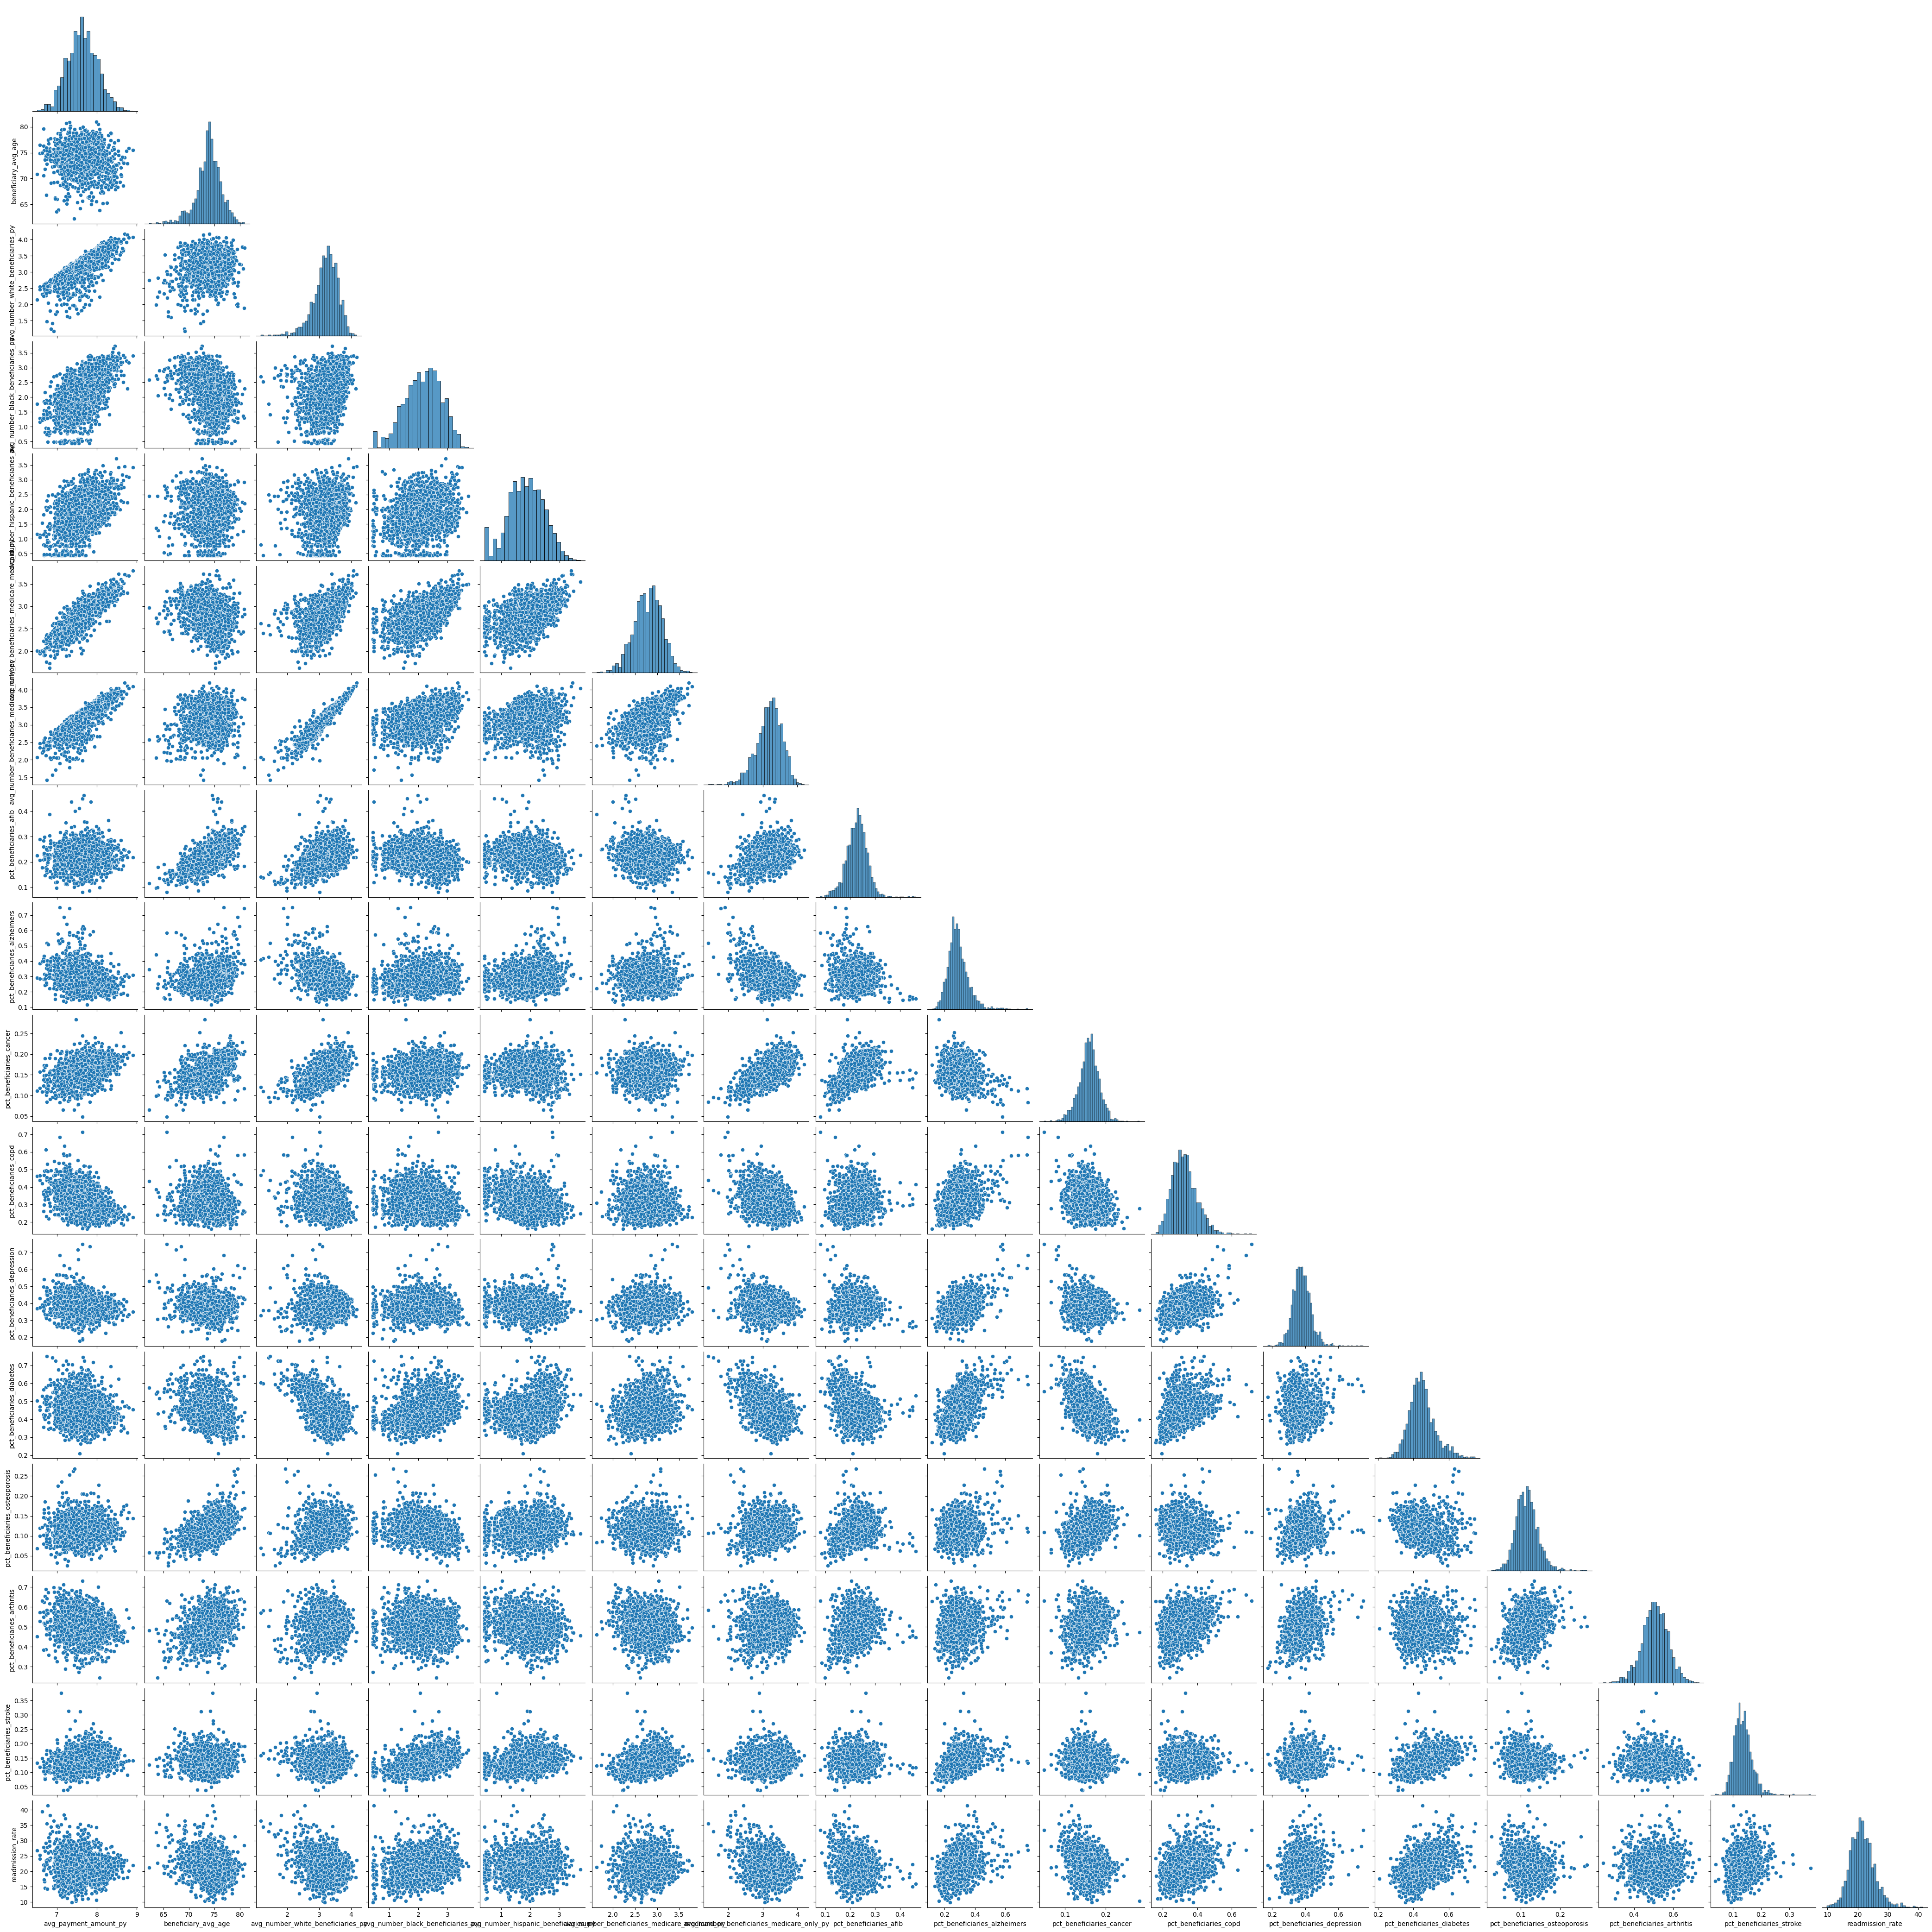

In [3]:
sns.pairplot(df, corner=True)

### Standardize and scale

## Fit

In [5]:
# A == BASE MODEL + RACE
features_A = [
    "avg_payment_amount_py",
    "beneficiary_avg_age",
    "pct_beneficiaries_alzheimers",
    "pct_beneficiaries_cancer",
    "pct_beneficiaries_copd",
    "pct_beneficiaries_diabetes",
    "pct_beneficiaries_osteoporosis",
    "pct_beneficiaries_arthritis",
    # "pct_beneficiaries_psychotic_disorders",
    "pct_beneficiaries_stroke",
    "avg_number_beneficiaries_medicare_medicaid_py",
    "avg_number_beneficiaries_medicare_only_py",
    "avg_number_white_beneficiaries_py",
    "avg_number_black_beneficiaries_py",
    "avg_number_hispanic_beneficiaries_py",
]

# B == BASE MODEL

features_B = [
    "avg_payment_amount_py",
    "beneficiary_avg_age",
    "pct_beneficiaries_alzheimers",
    "pct_beneficiaries_cancer",
    "pct_beneficiaries_copd",
    "pct_beneficiaries_diabetes",
    "pct_beneficiaries_osteoporosis",
    "pct_beneficiaries_arthritis",
    # "pct_beneficiaries_psychotic_disorders",
    "pct_beneficiaries_stroke",
    "avg_number_beneficiaries_medicare_medicaid_py",
    "avg_number_beneficiaries_medicare_only_py",
]

X = df.drop(columns=["readmission_rate"])
X_standardized = process_features(X, features_A)
X_standardized.reset_index(drop=True, inplace=True)
y = df["readmission_rate"]
y.reset_index(drop=True, inplace=True)

In [6]:
X_standardized.head()

avg_payment_amount_py  beneficiary_avg_age  pct_beneficiaries_alzheimers  \
0               0.616527            -0.662476                     -0.395277   
1              -0.693932            -0.204110                      0.211827   
2               0.129398            -0.028736                     -0.140025   
3              -0.199726            -0.609315                      0.126878   
4              -0.471528            -0.143175                     -0.253379   

   pct_beneficiaries_cancer  pct_beneficiaries_copd  \
0                  0.042178               -0.005929   
1                 -0.755408                1.708604   
2                 -0.394777                1.516709   
3                 -0.943306                0.219639   
4                 -0.108999                0.146079   

   pct_beneficiaries_diabetes  pct_beneficiaries_osteoporosis  \
0                    0.421116                        0.060832   
1                   -0.210509                       -0.402811   
2                    0.111574                        0.064613   
3                    0.182273                       -1.318240   
4                    0.201629                        0.133635   

   pct_beneficiaries_arthritis  pct_beneficiaries_stroke  \
0                     1.076842                  1.515251   
1                     1.222284                 -0.068391   
2                     1.213699                  0.091189   
3                    -0.701245                 -0.106613   
4                     0.475211                  0.193070   

   avg_number_beneficiaries_medicare_medicaid_py  \
0                                       1.095091   
1                                       0.024363   
2                                       0.552597   
3                                      -0.339167   
4                                      -0.971529   

   avg_number_beneficiaries_medicare_only_py  \
0                                   0.787177   
1                                  -0.188783   
2                                   0.570916   
3                                   0.130768   
4                                  -0.086177   

   avg_number_white_beneficiaries_py  avg_number_black_beneficiaries_py  \
0                           0.836367                           1.238006   
1                           0.161851                          -1.550263   
2                           0.725732                           0.422926   
3                           0.126607                           0.590974   
4                          -0.076393                           0.135107   

   avg_number_hispanic_beneficiaries_py  
0                             -0.395493  
1                             -0.909268  
2                             -0.883228  
3                             -0.964374  
4                             -1.148425

In [16]:
num_iterations = 1000
results_list_A = []
results_list_B = []
for i in range(num_iterations):
    X_train, X_test, y_train, y_test = train_test_split(
        X_standardized,
        y,
        test_size=0.2,
    )
    X_train_A = sm.add_constant(X_train)
    X_test_A = sm.add_constant(X_test)

    X_train_B, X_test_B = X_train_A[features_B], X_test_A[features_B]
    X_train_B = sm.add_constant(X_train_B)
    X_test_B = sm.add_constant(X_test_B)

    # A- fit
    linear_model_A = sm.OLS(y_train, X_train_A)
    linear_model_A = linear_model_A.fit()

    # A- evaluate
    y_pred_A = linear_model_A.predict(X_test_A)
    mse_A = mean_squared_error(y_test, y_pred_A)
    r2_A = r2_score(y_test, y_pred_A)
    coefficients_A = linear_model_A.params[1:]  # Exclude the bias term

    results_A = {
        "iteration": i,
        "model": "Base + Race",
        "mse": mse_A,
        "rmse": np.sqrt(mse_A),
        "r2": r2_A,
        **coefficients_A.to_dict(),
    }
    results_list_A.append(results_A)

    # B- fit
    linear_model_B = sm.OLS(y_train, X_train_B)
    linear_model_B = linear_model_B.fit()

    # B- evaluate
    y_pred_B = linear_model_B.predict(X_test_B)
    mse_B = mean_squared_error(y_test, y_pred_B)
    r2_B = r2_score(y_test, y_pred_B)
    coefficients_B = linear_model_B.params[1:]  # Exclude the bias term
    results_B = {
        "iteration": i,
        "model": "Base",
        "mse": mse_B,
        "rmse": np.sqrt(mse_B),
        "r2": r2_B,
        **coefficients_B.to_dict(),
    }
    results_list_B.append(results_B)

# Create DataFrames for Models A and B
results_df_B = pd.DataFrame(results_list_B)
results_df_A = pd.DataFrame(results_list_A)

# Concatenate DataFrames for Models A and B
results_df = pd.concat([results_df_B, results_df_A], ignore_index=True)

## Eval

Text(0.5, 1.0, 'R2')

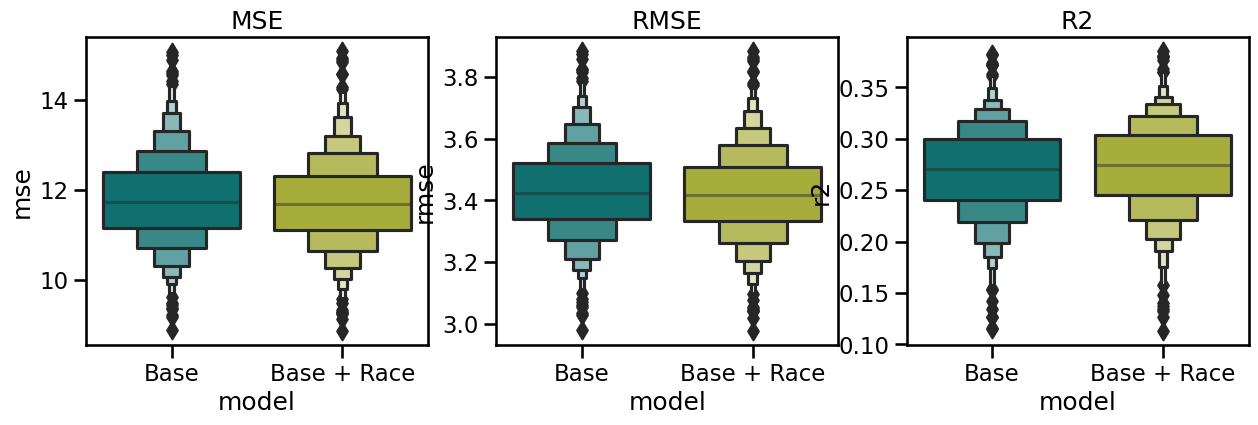

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
pal = ["#008080", "#B7C027"]
sns.boxenplot(data=results_df, x="model", y="mse", dodge=False, ax=ax[0], palette=pal)
sns.boxenplot(data=results_df, x="model", y="rmse", dodge=False, ax=ax[1], palette=pal)
sns.boxenplot(data=results_df, x="model", y="r2", dodge=False, ax=ax[2], palette=pal)

ax[0].set_title("MSE")
ax[1].set_title("RMSE")
ax[2].set_title("R2")

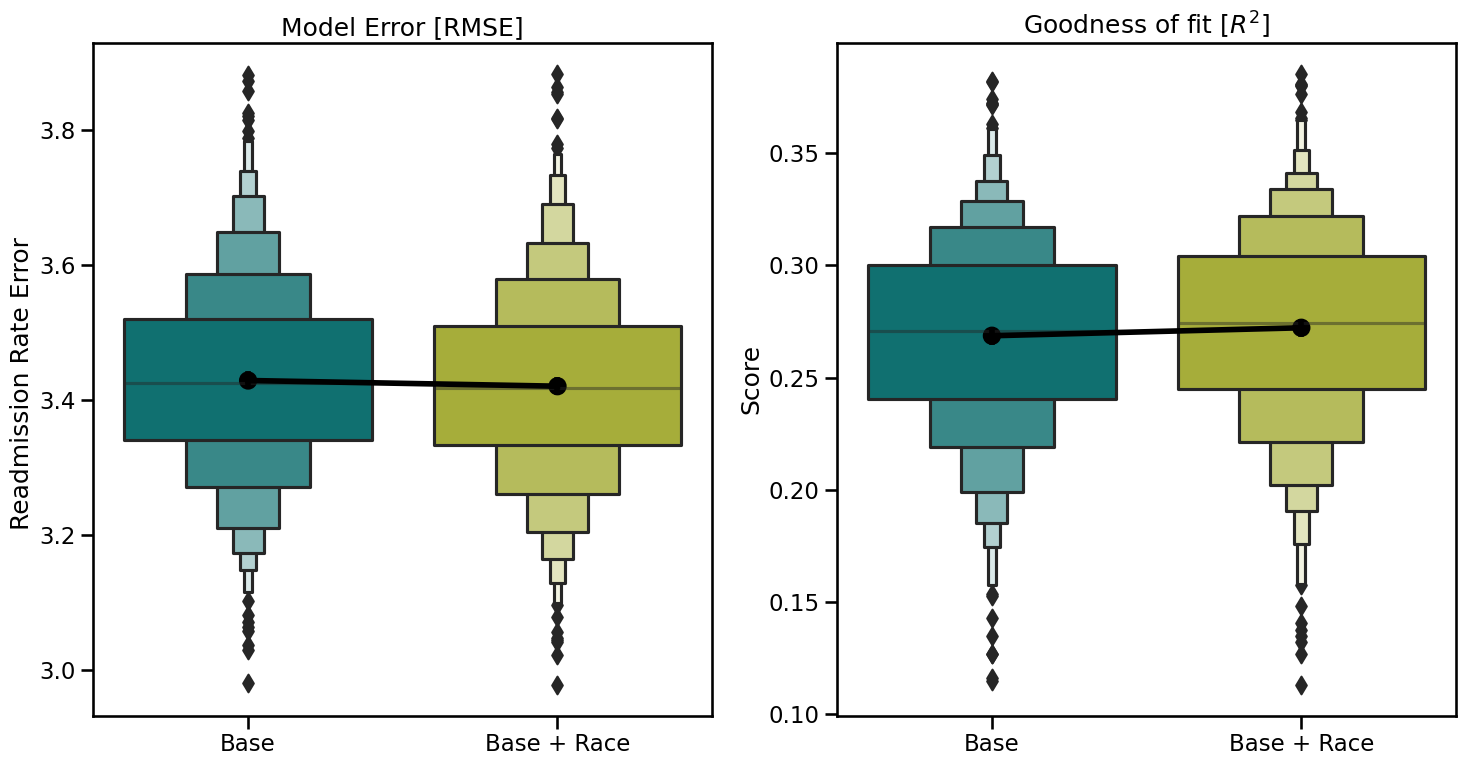

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
pal = ["#008080", "#B7C027"]
# sns.boxenplot(data=results_df, x="model", y="mse", dodge=False, ax=ax[0], palette=pal)
sns.boxenplot(data=results_df, x="model", y="rmse", dodge=False, ax=ax[0], palette=pal)
sns.pointplot(data=results_df, x="model", y="rmse", ax=ax[0], color="k")
sns.boxenplot(data=results_df, x="model", y="r2", dodge=False, ax=ax[1], palette=pal)
sns.pointplot(data=results_df, x="model", y="r2", ax=ax[1], color="k")

# ax[0].set_title("MSE")
ax[0].set_title("Model Error [RMSE]")
ax[1].set_title("Goodness of fit [$R^2$]")
ax[0].set(xlabel=(""), ylabel=("Readmission Rate Error "))
ax[1].set(xlabel=(""), ylabel=("Score"))
plt.tight_layout()

In [10]:
# Separate MSE scores for models A and B
mse_A = results_df[results_df["model"] == "Base + Race"]["mse"]
mse_B = results_df[results_df["model"] == "Base"]["mse"]

# Perform a paired t-test
t_statistic, p_value = ttest_rel(mse_A, mse_B)

print("Paired t-test results:")
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")

# Interpret the p-value to determine if the models are significantly different
alpha = 0.05  # Significance level
if p_value < alpha:
    print("The models are significantly different.")
else:
    print("There is no significant difference between the models.")

Paired t-test results:
t-statistic: -24.508210460710597
p-value: 3.337893648941294e-116
The models are significantly different.


In [11]:
# printed out coefficients_A_mean and manually mapped to the themes list
# coefficients_A_mean
themes = [
    "X",  # funding
    "Patient Mix",
    "Patient Mix",
    "Patient Mix",
    "Patient Mix",
    "Patient Mix",
    "Patient Mix",
    "Patient Mix",
    # "Patient Mix",
    "Patient Mix",
    "Y",  # insurance
    "Y",  # insurance
    "Z",  # race
    "Z",  # race
    "Z",  # race
]

In [12]:
for col in log_transform:
    results_df[col] = 10 ** (results_df[col])

# Calculate mean coefficients and standard deviations for models A and B
coefficients_A_mean = results_df[results_df["model"] == "Base + Race"][
    features_A
].mean()
coefficients_A_std = results_df[results_df["model"] == "Base + Race"][features_A].std()

coefficients_B_mean = results_df[results_df["model"] == "Base"][features_A].mean()
coefficients_B_std = results_df[results_df["model"] == "Base"][features_A].std()

# Sort coefficients for model A by absolute value in descending order
# coefficients_A_sorted_idx = (
#     np.abs(coefficients_A_mean).sort_values(ascending=True).index
# )
# coefficients_A_mean_sorted = coefficients_A_mean[coefficients_A_sorted_idx]
# coefficients_A_std_sorted = coefficients_A_std[coefficients_A_sorted_idx]
custom_sort_order_A = np.lexsort((np.abs(coefficients_A_mean), themes))
coefficients_A_mean_sorted = coefficients_A_mean.iloc[custom_sort_order_A]
coefficients_A_std_sorted = coefficients_A_std.iloc[custom_sort_order_A]

# Sort coefficients for model B using the same sorting order as model A
# coefficients_B_mean_sorted = coefficients_B_mean[coefficients_A_sorted_idx]
# coefficients_B_std_sorted = coefficients_B_std[coefficients_A_sorted_idx]
coefficients_B_mean_sorted = coefficients_B_mean.iloc[custom_sort_order_A]
coefficients_B_std_sorted = coefficients_B_std.iloc[custom_sort_order_A]

# custom_y_labels = (
#     [  # have to make plot first and then can write out these short hand labels
#         "N White",
#         "N Hispanic",
#         "N Black",
#         "N Medicare Only",
#         "N Dual Enroll.",
#         "Avg Payment",
#         "Avg Age",
#         "% Psych. Dis.",
#         "% COPD",
#         "% AD",
#         "% Arth.",
#         "% Stroke",
#         "% Osteo.",
#         "% Cancer",
#         "% Diabetes",
#     ]
# )

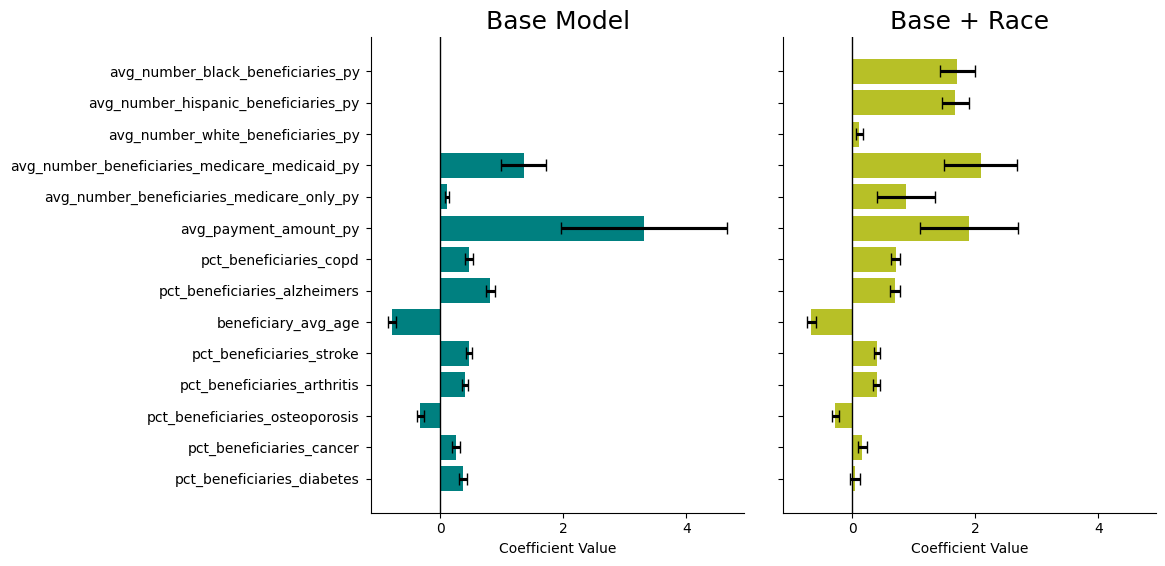

In [13]:
# Create a fig
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)
sns.set_context("talk")
# Plot coefficients for model A with error bars
axs[1].barh(
    coefficients_A_mean_sorted.index,
    coefficients_A_mean_sorted.values,
    xerr=coefficients_A_std_sorted,
    capsize=4,
    color=pal[1],
)
axs[1].set_title("Base + Race")
axs[1].set_xlabel("Coefficient Value")

# Plot coefficients for model B with error bars
axs[0].barh(
    coefficients_B_mean_sorted.index,
    coefficients_B_mean_sorted.values,
    xerr=coefficients_B_std_sorted,
    capsize=4,
    color=pal[0],
)

axs[0].set_title("Base Model")
axs[0].set_xlabel("Coefficient Value")
# axs[0].set_ylabel("Features")
# axs[0].set_yticks(range(len(custom_y_labels)))
# axs[0].set_yticklabels(custom_y_labels)
axs[0].yaxis.set_tick_params(pad=5)


for ax in axs:
    ax.axvline(x=0, color="black", linewidth=1)
# Adjust layout and display the plot
plt.tight_layout()
sns.despine()

In [ ]:
results_df.to_csv("lm_results_df.csv", index=False)